# Setup

### General Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from __future__ import print_function

import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


### Google Drive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#os.chdir('/content/drive/My Drive/CA4015/Assignment 4/Assignment_4')   # Daniel
#os.chdir('/content/drive/My Drive/CA4015/Assignment_4/') # John
os.chdir('/content/drive/My Drive/College - 4th Year/CA4015_AdvancedML/Assignment_4') # Liam

### Define Utility Functions

In [ ]:
%%capture
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-rstd_acc
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-rstd_acc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730117 sha256=406421386bcd010e05be5843515e5d2a88c164d1134a70ebfe5280d3fdf3fd24
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0mr6d1f/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.1.0
    Uninstalling altair-4.1.0:
      Successfully uninstalled altair-4.1.0
Done installing Altair.


# Loading Data

Here, we read in each DataFrame and inspect each to familiarise ourselves with the data.

In [ ]:
artists = pd.read_csv("data/last.fm/artists.dat", delimiter="\t")
artists_cols = ['id', 'name', 'url', 'pictureURL']
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [ ]:
u_t_artists = pd.read_csv("data/last.fm/user_taggedartists.dat", delimiter="\t")
u_t_artists_cols = ['userID', 'artistID', 'tagID', 'day', 'month', 'year']
u_t_artists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [ ]:
uta_timestamps = pd.read_csv("data/last.fm/user_taggedartists-timestamps.dat",delimiter="\t")
uta_timestamps_cols = ['userID', 'artistID', 'tagID', 'timestamp']
uta_timestamps.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


Above, we can see that this file holds the same information as the previous one but instead of a date, a *timestamp* is provided.

In [ ]:
user_artists = pd.read_csv("data/last.fm/user_artists.dat",delimiter="\t")
user_artists_cols = ['userID', 'artistID', 'weight']
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


The *weight* column above is indicative of a listening count for each [user, artist] pair according to the documentation provided with the dataset.

In [ ]:
user_friends = pd.read_csv("data/last.fm/user_friends.dat",delimiter="\t")
user_friends_cols = ['userID', 'friendID']
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [ ]:
user_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25434 entries, 0 to 25433
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    25434 non-null  int64
 1   friendID  25434 non-null  int64
dtypes: int64(2)
memory usage: 397.5 KB


The above DataFrame provides the friend relationships between users on the platform. There are 25,434 rows which represent 12,717 bidirectional relationships whereby each friend relationship occurs twice in the DataFrame.



In [ ]:
tags = pd.read_csv("data/last.fm/tags.dat",delimiter="\t", encoding='latin-1')
tags_cols = ['tagID', 'tagValue']
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


The above DataFrame is a unique list of the tags assigned to artists by users. The next step is to check for missing values in all of the DataFrames...

### Chekcing for Missing Values

In [ ]:
print("user_artists: ", user_artists.isnull().values.any())
print("user_friends: ", user_friends.isnull().values.any())
print("u_t_artists: ", u_t_artists.isnull().values.any())
print("uta_timestamps: ",uta_timestamps.isnull().values.any())
print("artists: ", artists.isnull().values.any())
print("tags: ", tags.isnull().values.any())

user_artists:  False
user_friends:  False
u_t_artists:  False
uta_timestamps:  False
artists:  True
tags:  False


The *artists* table does contain null values, so the next step is to investigate these.

In [ ]:
artists.isnull().any()

id            False
name          False
url           False
pictureURL     True
dtype: bool

The only column which contains null values is the *pictureURL* column. This doesn't affect our work so there is no need to remove or clean any instances.

### Reindexing ID Columns

All of the user, artists and tag IDs do not start at zero. For the sake of efficiency later on, we will change the IDs in each DataFrame.

In [ ]:
user_artists["userID"] = user_artists["userID"].apply(lambda x: str(x-2))
user_artists["artistID"] = user_artists["artistID"].apply(lambda x: str(x-1))

artists["id"] = artists["id"].apply(lambda x: str(x-1))

u_t_artists["userID"] = u_t_artists["userID"].apply(lambda x: str(x-2))
u_t_artists["artistID"] = u_t_artists["artistID"].apply(lambda x: str(x-1))
u_t_artists["tagID"] = u_t_artists["tagID"].apply(lambda x: str(x-1))

uta_timestamps["userID"] = uta_timestamps["userID"].apply(lambda x: str(x-2))
uta_timestamps["artistID"] = uta_timestamps["artistID"].apply(lambda x: str(x-1))
uta_timestamps["tagID"] = uta_timestamps["tagID"].apply(lambda x: str(x-1))

tags["tagID"] = tags["tagID"].apply(lambda x: str(x-1))

user_friends["userID"] = user_friends["userID"].apply(lambda x: str(x-2))
user_friends["friendID"] = user_friends["friendID"].apply(lambda x: str(x-2))

In [ ]:
print('Unique userID list: ', user_artists.userID.unique())
print('Unique artistID list: ', user_artists.artistID.unique())

Unique userID list ['0' '1' '2' ... '2095' '2097' '2098']
Unique artistID list ['50' '51' '52' ... '18727' '18728' '18729']


In [ ]:
user_artists.describe(include=[np.object])

,userID,artistID
count,92834,92834
unique,1892,17632
top,459,88
freq,50,611


We have now changed the IDs to start from 0 but the number of unique userIDs in the *user_artists* table the doesn't match the last userID and artistID. So for both cases, we cannot assume that the index of the table equals the ID.

In [ ]:
tags.describe(include=[np.object])

,tagID,tagValue
count,11946,11946
unique,11946,11946
top,10200,liam gallagher
freq,1,1


Now, we write the cleaned DataFrames to our shared Google Drive folder.

In [ ]:
#Don't run this cell again
"""
user_artists.to_csv('data_clean/user_artists.csv')
user_friends.to_csv('data_clean/user_friends.csv')
u_t_artists.to_csv('data_clean/u_t_artists.csv')
uta_timestamps.to_csv('data_clean/uta_timestamps.csv')
artists.to_csv('data_clean/artists.csv')
tags.to_csv('data_clean/tags.csv')
"""

"\nuser_artists.to_csv('data_clean/user_artists.csv')\nuser_friends.to_csv('data_clean/user_friends.csv')\nu_t_artists.to_csv('data_clean/u_t_artists.csv')\nuta_timestamps.to_csv('data_clean/uta_timestamps.csv')\nartists.to_csv('data_clean/artists.csv')\ntags.to_csv('data_clean/tags.csv')\n"

It may also be conveninet to merge the *user_artist_tag* dataframe to show the actual tags assigned to artists using a left join. We then also save this our Drive.



In [ ]:
merged_uat = pd.merge(u_t_artists, tags, on = 'tagID', how= 'left')
"""
merged_uat.to_csv('data_clean/merged_user_artist_tags.csv')
"""


"\nmerged_uat.to_csv('data_clean/merged_user_artist_tags.csv')\n"

# Data Exploration

To become more familiar with the data which we'll be working with, we are going to do some simple data exploration by firstly examining the most common tags.

### Analysis of Tags

In [ ]:
tag_counts = merged_uat[['userID', 'tagValue']].groupby('tagValue').count().reset_index()
top_tags = tag_counts.sort_values('userID', ascending=False).rename(columns={'userID':'count'}).head(20)
top_tags

,tagValue,count
7473,rock,7503
6802,pop,5418
441,alternative,5251
2709,electronic,4672
4393,indie,4458
...,...,...
5608,metal,1729
497,ambient,1699
207,90s,1615
6160,new wave,1595


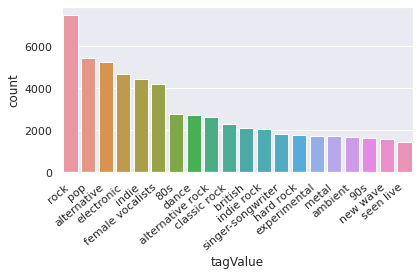

In [ ]:
ax = sns.barplot(x="tagValue", y="count", data=top_tags)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

From the plot above, we can see the top tags and most are not very surprising. 'rock' is the most widely assigned tag comfortably.

### Analysis of Users' Interaction with Artists

In [ ]:
user_artists.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


The *weight* column in the above DataFrame is representative of the listening count of the user for that particular artist, according to the documentation. Let's examine the distribution of this weight column.

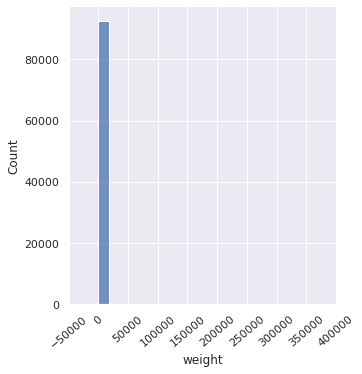

In [ ]:
ax = sns.displot(data = user_artists, x = 'weight', bins = 20)
ax.set_xticklabels(rotation=40)
plt.show()

From above, we can clearly see that some outlier weights are heavily skewing this distribution. Let's get a better look at this by plotting a box chart.

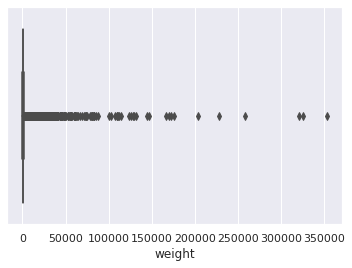

In [ ]:
sns.boxplot(data=user_artists, x="weight")

In [ ]:
user_artists.weight.describe()

count    92834.000
mean       745.244
std       3751.322
min          1.000
25%        107.000
50%        260.000
75%        614.000
max     352698.000
Name: weight, dtype: float64

The box plot above underscores the heavy skew in this distribution along with the difference between the upper quartile and max value which can also be seen above.

### Normalising the Weights

Firstly, let's attempt to z-standardise the weights and see if that produces a nicer distribution.

In [ ]:
std_user_artists = user_artists.copy()
cols = list(std_user_artists.columns)
cols.remove('userID')
cols.remove('artistID')
#user_artists[cols]
for col in cols:
    col_zscore = col + '_zscore'
    std_user_artists[col_zscore] = (std_user_artists[col] - std_user_artists[col].mean())/std_user_artists[col].std(ddof=0)
std_user_artists

,userID,artistID,weight,weight_zscore
0,0,50,13883,3.502
1,0,51,11690,2.918
2,0,52,11351,2.827
3,0,53,10300,2.547
4,0,54,8983,2.196
...,...,...,...,...
92829,2098,18725,337,-0.109
92830,2098,18726,297,-0.119
92831,2098,18727,281,-0.124
92832,2098,18728,280,-0.124


In [ ]:
std_user_artists.weight_zscore.describe()

count   92834.000
mean        0.000
std         1.000
min        -0.198
25%        -0.170
50%        -0.129
75%        -0.035
max        93.821
Name: weight_zscore, dtype: float64

Z-standardisation does not have the desired effect however. The highest z-score is 93.821 and the upper quartile is less than zero, so we will have to try another method.

Another possibility would be to set the value of the outliers to a lower maximum value (i.e. put a cap on the weights) and then use a max-min scaler to scale the remaining weights into an easy-to-interpret 1-5 scale.

After some experimentation, we think a reasonable cap for the weights is 1500. Therefore, we are going to set any weights above 1500 to this value.

In [ ]:
user_artists[user_artists["weight"] > 1500]["weight"] = 1500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
indexes = user_artists[user_artists["weight"] > 1500].index

In [ ]:
# Set the value of all of these weights to 1500
user_artists.iloc[indexes,2] = 1500

Now, the distribution is not as heavily skewed as can be seen from the box plot below...

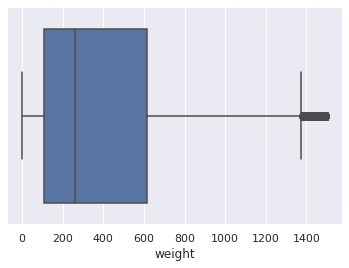

In [ ]:
sns.boxplot(data=user_artists, x="weight")

The code below scales the weights to an interval between 1-5 using an interpolation function from NumPy.

In [ ]:
user_artists['alt_weight'] = float

min_weight = min(user_artists.weight)
max_weight = max(user_artists.weight)

for i in range(0,len(user_artists)):
  user_artists.alt_weight.iloc[i] = np.interp(user_artists.weight.iloc[i],[min_weight,max_weight],[1,5])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


The plot below shows the new distribution of weights...

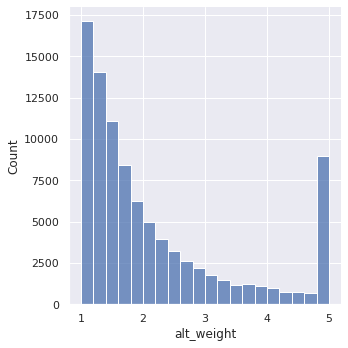

In [ ]:
ax = sns.displot(data = user_artists, x = 'alt_weight', bins = 20)

We can now write this DataFrame with normalised weights to our Drive and we are ready to begin builidng our recommender system.

In [ ]:
# user_artists.to_csv('data_clean/new_user_artists.csv', index=False)